In [32]:
# importing all pre-processing and metric libraries needed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error as mae, mean_squared_error as mse

sns.set()

In [33]:
# import files with model code
from node import node
from network import network_lstm

In [34]:
# read data
# df=pd.read_csv("./TSLA.csv",index_col="Date",parse_dates=True)
df = pd.read_csv("https://raw.githubusercontent.com/batuljp/ML_Assg_Datasets/main/TSLA.csv", index_col = "Date", parse_dates = True)

In [35]:
# check dimensions
df.shape

(2416, 6)

In [36]:
# columns available
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [37]:
# print few rows
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800
2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800
2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900


-  Open and close are the prices at which a stock began and ended trading in the same period. Volume is the total amount of trading activity. Adjusted values factor in corporate actions such as dividends, stock splits, and new share issuance
- In this project we are going to use only one column i.e `Adj close`  which generated from closing stocks values

In [38]:
# dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2416 entries, 2010-06-29 to 2020-02-03
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2416 non-null   float64
 1   High       2416 non-null   float64
 2   Low        2416 non-null   float64
 3   Close      2416 non-null   float64
 4   Adj Close  2416 non-null   float64
 5   Volume     2416 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 132.1 KB


In [39]:
# check summary stats
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2416.000000,2416.000000,2416.000000,2416.000000,2416.000000,2.416000e+03
mean,186.271147,189.578224,182.916639,186.403651,186.403651,5.572722e+06
std,118.740163,120.892329,116.857591,119.136020,119.136020,4.987809e+06
min,16.139999,16.629999,14.980000,15.800000,15.800000,1.185000e+05
25%,34.342498,34.897501,33.587501,34.400002,34.400002,1.899275e+06
50%,213.035004,216.745002,208.870002,212.960007,212.960007,4.578400e+06
75%,266.450012,270.927513,262.102501,266.774994,266.774994,7.361150e+06
max,673.690002,786.140015,673.520020,780.000000,780.000000,4.706500e+07


- Opening and Closing stock has an average same value with very slight in increase from opening stock.


In [40]:
# check if there are null values
df.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

Text(0.5, 1.0, 'How Trend of stock was for the period')

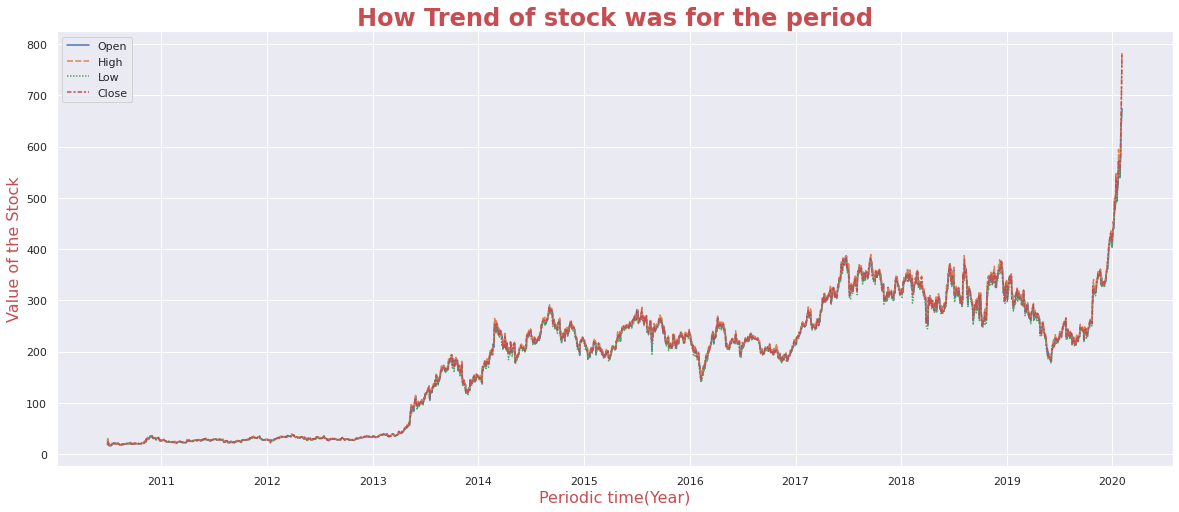

In [41]:
# Visualizing trends 
plt.figure(figsize=(20,8))
sns.lineplot(data=df.iloc[:,:-2])
plt.ylabel("Value of the Stock", fontsize=16,c='r')
plt.xlabel("Periodic time(Year)", fontsize=16,c='r')
plt.title("How Trend of stock was for the period", fontsize=24,c='r', fontweight='bold')

In [42]:
# Returns rolling stock between two dates given 
# It gives the moving average between from_date and to_date that the window specifies
def get_sales_from_date(title, from_date="2020-01-01", to_date="2021-01-01", window=28):
    data = df.loc[f"{from_date}":f"{to_date}"].rolling(window).mean()
    plt.figure(figsize=(15,8)),
    sns.lineplot(data=data.iloc[:,4:5])
    plt.title(f"{title}", fontsize=17, c='r')


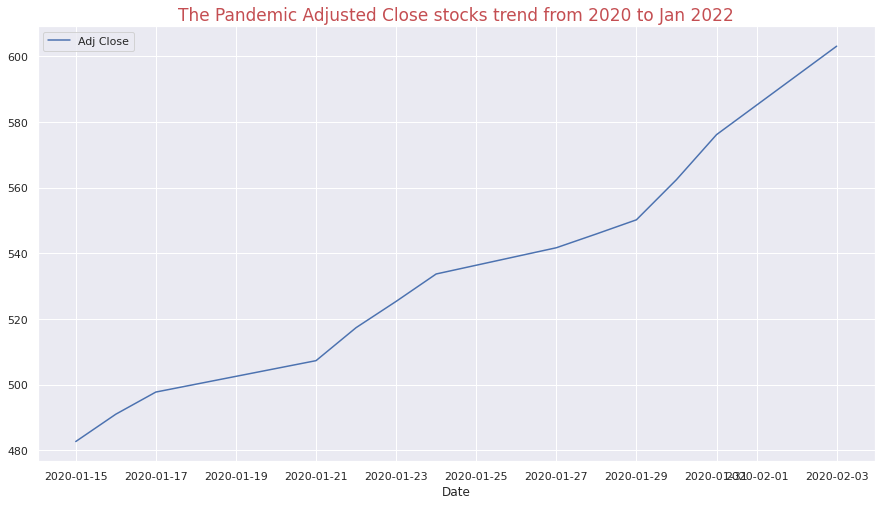

In [43]:
# 7 day moving average
get_sales_from_date("The Pandemic Adjusted Close stocks trend from 2020 to Jan 2022", "2020-01-01","2022-01-01",10)

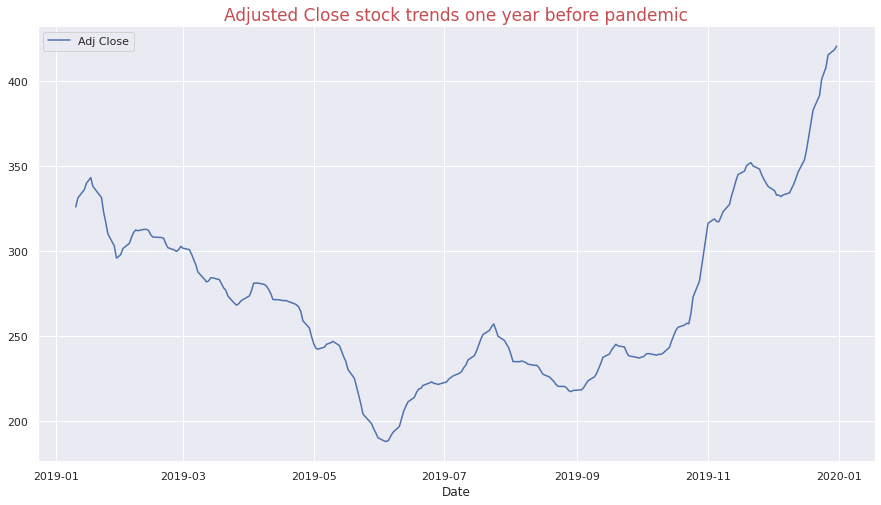

In [44]:
# 1 year before pandemic
get_sales_from_date("Adjusted Close stock trends one year before pandemic", "2019-01-01","2020-1-01",7)

In [45]:
# create a function to create X features and y labels

def create_dataset(data, return_shape=1):
    df_X, df_Y = [], []
    for i in range(len(data)-return_shape-1):
        a = data[i:(i+return_shape), 0]
        df_X.append(a)
        df_Y.append(data[i + return_shape, 0])
    return np.array(df_X), np.array(df_Y)

In [46]:
# we are only going to use `Adj Close` column since it shows market closing cost
target = df["Adj Close"].values

# fix random seed for reproducibility
np.random.seed(2022)

# use closing stock column
# dataset = target/target.max()
dataset = target.reshape(-1,1)

# normalizing the dataset
scaler = MinMaxScaler()
dataset = scaler.fit_transform(dataset)


# reshape into X=t and Y=t+1, timestep 10
return_shape = 4
trainX, trainY = create_dataset(dataset, return_shape)


trainX.shape , trainY.shape

((2411, 4), (2411,))

In [47]:
# create optimizer Class.

#opt.py
class Optimizer_Adam:
    #constructor
    def __init__(self, lr_value, one_beta, two_beta,value_epsilon, decay_value):
        self.reps = 1
        self.lr_value = lr_value
        self.one_beta = one_beta
        self.value_epsilon = value_epsilon
        self.decay_value = decay_value
        self.two_beta = two_beta

    def optimize(self, func_params, gd):

        shape_before = [x.shape for x in func_params]
        lr_value = self.lr_value
        if self.decay_value > 0:
            test=self.decay_value * self.reps
            test +=1
            lr_value = (1/(test))*lr_value
        unc_params = [x.flatten() for x in func_params]
        my_t = self.reps+1
        holderone=np.sqrt(1 - np.power(self.two_beta, my_t))
        holdertwo=1 - np.power(self.one_beta, my_t)
        lrt = holderone/holdertwo
        lrt = lr_value*lrt
        gd = [x.flatten() for x in gd]
        if not hasattr(self, 'ab'):
            self.ab = [np.zeros(p.shape) for p in func_params]
            #continue
            self.bc = [np.zeros(p.shape) for p in func_params]
        my_ret = [None]*len(func_params)
        for a, b, c, d, e in zip(range(len(func_params)), func_params, gd, self.ab, self.bc):
            holderonea = (self.one_beta * d)
            holderoneb = (1 - self.one_beta)
            dt = holderonea+holderoneb*c
            holderonea=(self.two_beta*e)
            holderoneb=(1-self.two_beta)
            et = holderonea + holderoneb * np.square(c)
            bt = lrt*dt
            bx= np.sqrt(et) + self.value_epsilon
            bt = b-bt/bx
            self.ab[a] = dt
            my_ret[a] = bt
            self.bc[a] = et
        self.reps = self.reps+1
  
        for a in range(len(my_ret)):
            #do
            my_ret[a] = my_ret[a].reshape(shape_before[a])
        #return
        return np.array(my_ret)


In [48]:
#class to create initial weights and bias
class InitialParamaterSetter:
    def __init__(self, layers, X):
        #set layers and size
        self.layers = layers
        self.X = X
        total_length = X + layers
        
        #create optimizer with variables
        lr=.1
        first_beta = .9
        second_beta = .999
        epsilon = 0
        decay = 0
        self.opt=Optimizer_Adam(lr, first_beta, second_beta,epsilon, decay)

        # create random weights
        np.random.seed(0)
        self.weight_one = (np.random.rand(layers, total_length) * (.1 + .1) - .1)*.1
        np.random.seed(0)
        self.weight_two = (np.random.rand(layers, total_length) * (.1 + .1) - .1)*.1
        np.random.seed(0)
        self.weight_three = (np.random.rand(layers, total_length) * (.1 + .1) - .1)*.1
        np.random.seed(0)
        self.weight_four = (np.random.rand(layers, total_length) * (.1 + .1) - .1)*.1

        # random biases
        np.random.seed(0)
        self.bias_one = (np.random.rand(layers) * (.1 + .1) - .1)*.1
        np.random.seed(0)
        self.bias_two = (np.random.rand(layers) * (.1 + .1) - .1)*.1
        np.random.seed(0)
        self.bias_three = (np.random.rand(layers) * (.1 + .1) - .1)*.1
        np.random.seed(0)
        self.bias_four = (np.random.rand(layers) * (.1 + .1) - .1)*.1
        
        # derivatives of loss functions
        self.weight_one_difference = np.zeros((layers, total_length)) 
        self.weight_two_difference = np.zeros((layers, total_length)) 
        self.weight_three_difference = np.zeros((layers, total_length)) 
        self.weight_four_difference = np.zeros((layers, total_length)) 
        self.bias_one_weight = np.zeros(layers) 
        self.bias_two_weight = np.zeros(layers) 
        self.bias_three_weight = np.zeros(layers) 
        self.bias_four_weight = np.zeros(layers) 

In [49]:
# function to train X and Y
def trainer_ftn(X,Y,current_loss,epoch, n_iter):
    #number of hidden layers
    hidden_layers_num = 10
    X_size = 4

    #set parameters
    paramters_of_lstm = InitialParamaterSetter(hidden_layers_num, X_size)
    lr=.1
    first_beta = .9
    second_beta = .999
    epsilon = 0
    decay = 0

    #initialize the network
    initial_network = network_lstm(paramters_of_lstm,current_loss)
    
    array_of_loss=[]
    bestLoss=1e7
    if epoch%2 ==0:
      print(f"Epoch----[{epoch}]  Training...")

    #train the model on several epochs
    for ZZ in range(n_iter):
        for curr_index in range(len(Y)):
            initial_network.xlist.append(X[curr_index])
            if len(initial_network.xlist) > len(initial_network.n_list):
            # new parameters for cell
              param_one = np.zeros(hidden_layers_num)
              param_two = np.zeros(hidden_layers_num)
              param_three = np.zeros(hidden_layers_num)
              param_four = np.zeros(hidden_layers_num)
              param_five = np.zeros(hidden_layers_num)
              param_six = np.zeros(hidden_layers_num)
              diff_bottom_h = np.zeros_like(param_six)
              diff_bottom_s = np.zeros_like(param_five)
              #create newtork
              initial_network.n_list.append(node(initial_network.paramters_of_lstm, param_one, param_two, param_three, param_four, param_five, param_six, diff_bottom_h, diff_bottom_s))
            #find newest index
            data_index = len(initial_network.xlist) - 1
            #check bottom
            if(data_index == 0):
              initial_network.n_list[data_index].data_bottom(X[curr_index])
            elif(data_index != 0):
              prev_one = initial_network.n_list[data_index - 1].param_five
              prev_two = initial_network.n_list[data_index - 1].param_six
              initial_network.n_list[data_index].data_bottom(X[curr_index], prev_one, prev_two)
        current_loss = initial_network.update_total_differences(Y)#, LossFtn)
        array_of_loss.append(current_loss)
        betterLoss = False
        if(current_loss<bestLoss):
          betterLoss = True
        if(betterLoss):
            final_network = network_lstm(paramters_of_lstm,current_loss)

        opt=Optimizer_Adam(lr, first_beta, second_beta,epsilon, decay)
        paramters_of_lstm.weight_one=paramters_of_lstm.opt.optimize(paramters_of_lstm.weight_one,paramters_of_lstm.weight_one_difference)
        paramters_of_lstm.weight_two=paramters_of_lstm.opt.optimize(paramters_of_lstm.weight_two,paramters_of_lstm.weight_two_difference)
        paramters_of_lstm.weight_three=paramters_of_lstm.opt.optimize(paramters_of_lstm.weight_three,paramters_of_lstm.weight_three_difference)
        paramters_of_lstm.weight_four=paramters_of_lstm.opt.optimize(paramters_of_lstm.weight_four,paramters_of_lstm.weight_four_difference)
        
        #use optimizer to fix bias
        new_lr = .001
        paramters_of_lstm.bias_one = paramters_of_lstm.bias_one- new_lr * paramters_of_lstm.bias_one_weight
        paramters_of_lstm.bias_two = paramters_of_lstm.bias_two - new_lr * paramters_of_lstm.bias_two_weight
        paramters_of_lstm.bias_three =   paramters_of_lstm.bias_two - new_lr * paramters_of_lstm.bias_three_weight
        paramters_of_lstm.bias_four =   paramters_of_lstm.bias_two - new_lr * paramters_of_lstm.bias_four_weight
        
        #reset all weights
        paramters_of_lstm.weight_one_difference = np.zeros_like(paramters_of_lstm.weight_one)
        paramters_of_lstm.weight_two_difference = np.zeros_like(paramters_of_lstm.weight_two) 
        paramters_of_lstm.weight_three_difference = np.zeros_like(paramters_of_lstm.weight_three) 
        paramters_of_lstm.weight_four_difference = np.zeros_like(paramters_of_lstm.weight_four) 
        paramters_of_lstm.bias_one_weight = np.zeros_like(paramters_of_lstm.bias_one)
        paramters_of_lstm.bias_two_weight = np.zeros_like(paramters_of_lstm.bias_two) 
        paramters_of_lstm.bias_three_weight = np.zeros_like(paramters_of_lstm.bias_three) 
        paramters_of_lstm.bias_four_weight = np.zeros_like(paramters_of_lstm.bias_four) 

        #clear list
        initial_network.xlist = []
    curr_index = 0
    for curr_index in range(len(Y)):
        final_network.xlist.append(X[curr_index])
        if len(final_network.xlist) > len(final_network.n_list):
            # create new state memory
            final_network.n_list.append(node(final_network.paramters_of_lstm, param_one, param_two, param_three, param_four, param_five, param_six, diff_bottom_h, diff_bottom_s))
            
        #find newest index number
        data_index = len(final_network.xlist) - 1
        if data_index == 0:
            final_network.n_list[data_index].data_bottom(X[curr_index])
        elif data_index != 0:
            prev_one = final_network.n_list[data_index - 1].param_five
            prev_two = final_network.n_list[data_index - 1].param_six
            final_network.n_list[data_index].data_bottom(X[curr_index], prev_one, prev_two)
    current_loss = final_network.update_total_differences(Y)
    layers =[final_network.n_list[curr_index].param_six[0] for curr_index in range(len(Y))]
    return array_of_loss, layers ,current_loss, final_network



- Since the dataset has over 2500 rows,
- We are going to train it in batches of 64 in each train.
- Predictions will then be concatenated together for final results.
- We are going to range the epochs to train as train_size/batchsize

In [50]:
# define epochs and Batch sizes to use.
BATCH_SIZE = 64
# DEFINE epochs
epochs = (trainX.shape[0]//BATCH_SIZE)+1
# we will iterate 1000 times for each 
N_ITER = 1000

In [51]:
# iterate and train all the data in the number of defines epochs 

# current start index for training
curr_ind = 0
# list to hold losses
epoch_loss =[]
# list to hold all predicitions
all_preds =[]

# iterate through all epochs while training with specified batch sizes of data
for epoch in range(epochs):
    #get training and testing dataset
    X_train = trainX[curr_ind:curr_ind +BATCH_SIZE]
    Y_train = trainY[curr_ind:curr_ind +BATCH_SIZE]
    #advance the batch index
    curr_ind = curr_ind +BATCH_SIZE
    #train the data
    losses, predictions,loss, model=trainer_ftn(X_train, Y_train, 'rmse', epoch+1, N_ITER)
    #add the stats
    epoch_loss.append(loss)
    all_preds = all_preds+predictions

Epoch----[2]  Training...
Epoch----[4]  Training...
Epoch----[6]  Training...
Epoch----[8]  Training...
Epoch----[10]  Training...
Epoch----[12]  Training...
Epoch----[14]  Training...
Epoch----[16]  Training...
Epoch----[18]  Training...
Epoch----[20]  Training...
Epoch----[22]  Training...
Epoch----[24]  Training...
Epoch----[26]  Training...
Epoch----[28]  Training...
Epoch----[30]  Training...
Epoch----[32]  Training...
Epoch----[34]  Training...
Epoch----[36]  Training...
Epoch----[38]  Training...


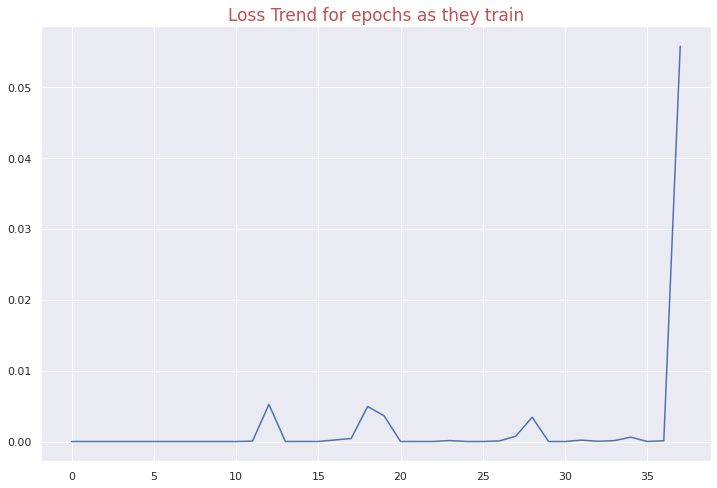

In [52]:
# plot the loss graph
plt.figure(figsize=(12,8))
plt.plot(epoch_loss)
plt.title("Loss Trend for epochs as they train", fontsize =17, c='r')
plt.show()

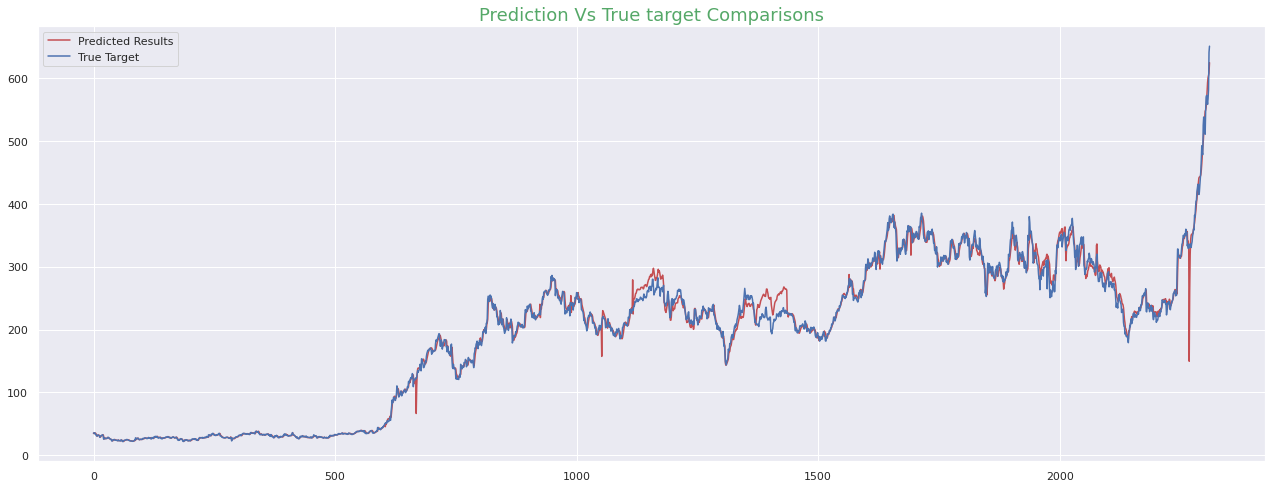

In [53]:
# plot the predictions vs real target
plt.figure(figsize=(22,8))
plt.plot(scaler.inverse_transform(np.array(all_preds[100:]).reshape(-1,1)), label ="Predicted Results", c='r')
plt.plot(scaler.inverse_transform(trainY[100:].reshape(-1,1)), label="True Target", c='b')
plt.title("Prediction Vs True Target Comparisons", fontsize=18, c='g')
plt.legend()

In [54]:
# lets get r2_score for line fitness , mse and mae results
print("MODEL STATISTICS RESULTS")
print(f"Mean Absolute Error   {mae(trainY, all_preds)}")
print(f"Mean Squared  Error   {mse(trainY, all_preds)}")
print(f"R2 score    {r2_score(trainY, all_preds)}")

MODEL STATISTICS RESULTS
Mean Absolute Error   0.008269043356059174
Mean Squared  Error   0.00020280879916088174
R2 score    0.9915556733839744
